In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torchvision.models as models
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
BATCH_SIZE = 64

## Data preprocessing

In [3]:
basic_transform = transforms.ToTensor()
full_ds =  datasets.GTSRB(root='.', split="train", transform=basic_transform, download=True)

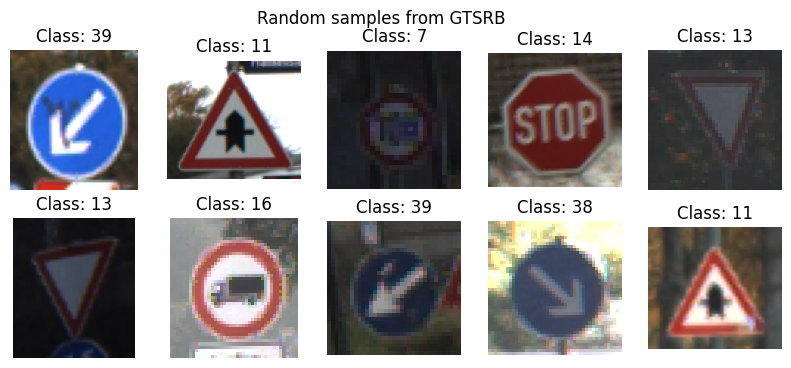

In [4]:
import random
indices = random.sample(range(len(full_ds)), 10)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for ax, i in zip(axes.flatten(), indices):
    img, label = full_ds[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"Class: {label}")
    ax.axis("off")

plt.suptitle("Random samples from GTSRB")
plt.show()

### Checking imbalance data

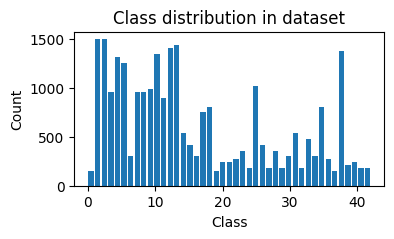

In [5]:
labels = [full_ds[i][1] for i in range(len(full_ds))]

plt.figure(figsize=(4,2))
plt.hist(labels, bins=len(set(labels)), rwidth=0.8)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class distribution in dataset")
plt.show()

In [6]:
classes = []
for img,label in full_ds:
    if label in classes:
        continue
    else:
        classes.append(label)
num_classes = len(classes)
print(num_classes)

43


### Split data to train and test

In [7]:
train_len = int(0.8*len(full_ds))
test_len = int(0.2*len(full_ds))
train_ds, test_ds = random_split(full_ds, [train_len, test_len])

### Augmentaion|

In [8]:
train_transforms = transforms.Compose([
    transforms.ColorJitter(brightness=1.0, contrast=0.5, saturation=1, hue=0.1),
    transforms.RandomEqualize(0.4),
    transforms.AugMix(),
    transforms.RandomHorizontalFlip(0.3),
    transforms.RandomVerticalFlip(0.3),
    transforms.GaussianBlur((3,3)),
    transforms.RandomRotation(30),
    transforms.Resize([50,50]),
    transforms.ToTensor(),
    
])

validation_transforms =  transforms.Compose([
    transforms.Resize([50,50]),
    transforms.ToTensor(),
    
])


train_ds.dataset.transforms = train_transforms
test_ds.dataset.transform = validation_transforms

### plot after augmantation

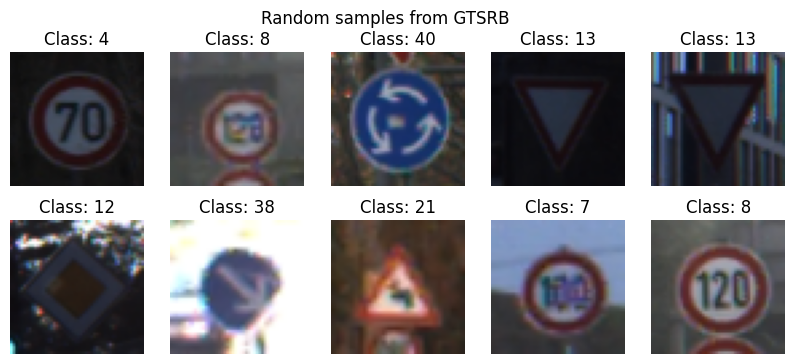

In [9]:
import random
indices = random.sample(range(len(train_ds)), 10)
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for ax, i in zip(axes.flatten(), indices):
    img, label = train_ds[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"Class: {label}")
    ax.axis("off")

plt.suptitle("Random samples from GTSRB")
plt.show()

In [10]:
train_loader = DataLoader(train_ds,BATCH_SIZE,shuffle=True)
test_loader = DataLoader(test_ds,BATCH_SIZE,shuffle=False)

## Model

In [11]:
img =train_ds[0]
img[0].shape

torch.Size([3, 50, 50])

In [12]:
class CrossAttentionBlock(nn.Module):
    def __init__(self, dim, heads=4):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=heads, batch_first=True)
    def forward(self, img_embedding , style):
        q = img_embedding
        k = style
        v = style
        out,_ = self.attn(q, k, v)
        return out + img_embedding

In [23]:
class Model(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
       
        backbone = models.resnet50(weights = None)
        self.feature_extractor = nn.Sequential(*list(backbone.children())[:-2])
        for param in self.feature_extractor.parameters():
            param.requires_grad = True

        self.flatten = nn.Flatten()

        self.fa = nn.Linear(2048*2*2,num_classes)
        
        

    def forward(self,x):
        ## res embedding
        x1 = self.feature_extractor(x)
        B, C, H, W = x1.shape
        x2 = x1.permute(0,2,3,1).reshape(B, H,W, C) 
        x3 =self.flatten(x2)
        fa = self.fa(x3) 

        return fa

## Train

In [24]:
model = Model().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
critetion = nn.CrossEntropyLoss()

In [25]:
for epoch in range(2):
    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        logits = model(x)
        #logits.shape [64, 43]  each image with 43 classes probability
        loss = critetion(logits,y.long())
        loss.backward()
        optimizer.step()
        print(loss)

tensor(3.9854, grad_fn=<NllLossBackward0>)
tensor(10.9278, grad_fn=<NllLossBackward0>)
tensor(12.1997, grad_fn=<NllLossBackward0>)
tensor(14.7527, grad_fn=<NllLossBackward0>)
tensor(13.2534, grad_fn=<NllLossBackward0>)
tensor(9.2735, grad_fn=<NllLossBackward0>)
tensor(12.7235, grad_fn=<NllLossBackward0>)
tensor(9.5514, grad_fn=<NllLossBackward0>)
tensor(8.0381, grad_fn=<NllLossBackward0>)
tensor(6.1359, grad_fn=<NllLossBackward0>)
tensor(5.0486, grad_fn=<NllLossBackward0>)
tensor(5.0305, grad_fn=<NllLossBackward0>)
tensor(4.1037, grad_fn=<NllLossBackward0>)
tensor(5.8603, grad_fn=<NllLossBackward0>)
tensor(3.8940, grad_fn=<NllLossBackward0>)
tensor(4.9776, grad_fn=<NllLossBackward0>)
tensor(4.2725, grad_fn=<NllLossBackward0>)
tensor(5.6586, grad_fn=<NllLossBackward0>)
tensor(6.1606, grad_fn=<NllLossBackward0>)
tensor(4.8174, grad_fn=<NllLossBackward0>)
tensor(4.0710, grad_fn=<NllLossBackward0>)
tensor(4.0753, grad_fn=<NllLossBackward0>)
tensor(3.9179, grad_fn=<NllLossBackward0>)
tensor